# Redukcja wymiarowości

Omówimy jedną z najpopularniejszych metod redukcji wymiarowości i spróbujemy zastosować ją do klasyfikacji obrazów - MNIST (o wymiarach 32x32=784 cech).

In [1]:
from sklearn.datasets import fetch_openml
import warnings

warnings.filterwarnings('ignore')

mnist = fetch_openml('mnist_784')
X = mnist.data
y = mnist.target

In [2]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)


In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

# ustaw parametry tylko na zbiorze treningowym
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

Użyjmy PCA do redukcji wymiarowości cech

In [4]:
from sklearn.decomposition import PCA

pca = PCA(.95).fit(X_train)

In [5]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Jak teraz wyglądają nasze zbiory?

In [10]:
print(X_train.shape)
print(X_train_pca.shape)

(52500, 784)
(52500, 328)


2


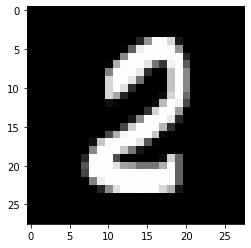

In [33]:
plt.imshow(scaler.inverse_transform(X_train)[3].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255))
print(y_train[3])

2


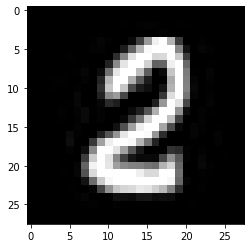

In [37]:
pca = PCA(0.95)
plt.imshow(scaler.inverse_transform(pca.inverse_transform(pca.fit_transform(X_train)))[3].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255))
print(y_train[3])

2


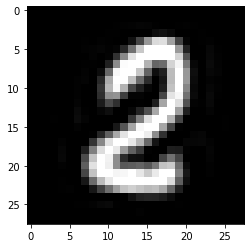

In [38]:
pca = PCA(0.9)
plt.imshow(scaler.inverse_transform(pca.inverse_transform(pca.fit_transform(X_train)))[3].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255))
print(y_train[3])

2


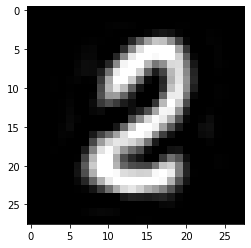

In [39]:
pca = PCA(0.8)
plt.imshow(scaler.inverse_transform(pca.inverse_transform(pca.fit_transform(X_train)))[3].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255))
print(y_train[3])

2


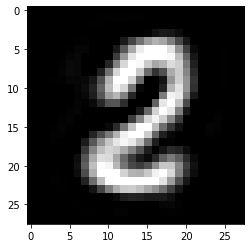

In [40]:
pca = PCA(0.7)
plt.imshow(scaler.inverse_transform(pca.inverse_transform(pca.fit_transform(X_train)))[3].reshape(28, 28),
              cmap = plt.cm.gray, interpolation='nearest',
              clim=(0, 255))
print(y_train[3])

In [6]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(solver='lbfgs').fit(X_train, y_train)
y_pred = model.predict(X_test)

In [7]:
model_pca = LogisticRegression(solver='lbfgs').fit(X_train_pca, y_train)
y_pred_pca = model_pca.predict(X_test_pca)

Sprawdźmy teraz jak dobrze działają nasze klasyfikatory.

In [11]:
from datasets import *

# !git clone https://github.com/PiotrJZielinski/ml-throwdown-datasets datasets/

In [12]:
print_results(calculate_metrics(y_test, y_pred), 'LogReg no PCA')
print_results(calculate_metrics(y_test, y_pred_pca), 'LogReg PCA')

Results for LogReg no PCA
----
  Accuracy:  0.9143428571428571
  Precision: 0.9131857687010335
  Recall:    0.9130847036209699
  F1 score:  0.9130267821149953
  Mislabeled 1499 out of 17500


Results for LogReg PCA
----
  Accuracy:  0.9176571428571428
  Precision: 0.9163994816580446
  Recall:    0.9163270329615131
  F1 score:  0.9162483231706808
  Mislabeled 1441 out of 17500




A jak wygląda czas uczenia?

In [13]:
def no_pca():
    LogisticRegression(solver='lbfgs').fit(X_train, y_train)
    
def pca():
    X_train_pca = PCA(.95).fit_transform(X_train)
    LogisticRegression(solver='lbfgs').fit(X_train_pca, y_train)

%timeit no_pca()
%timeit pca()

36.4 s ± 568 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
13.1 s ± 163 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Możemy teraz spróbować pobawić się walidacją krzyżową oraz zmianą parametru `n_components`.

In [17]:
from sklearn.decomposition import PCA

def cross_validate_pca(classifier, kfold, X, y, params=None, n_components=0.95):
    if params is None:
        params = {}
    predicted = []
    target = []
    for train_index, test_index in kfold.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        features = PCA(n_components).fit(X_train)
        X_train = features.transform(X_train)
        X_test = features.transform(X_test)
        clf = classifier(**params).fit(X_train, y_train)
        predicted = np.concatenate((predicted,
                                    clf.predict(X_test)))
        target = np.concatenate((target,
                                 y_test))
    metrics = calculate_metrics(target, predicted)
    cm = confusion_matrix(target, predicted)
    return metrics, cm

Results for LR-PCA
----
  Accuracy:  0.9102714285714286
  Precision: 0.9089525271966025
  Recall:    0.9088471685305581
  F1 score:  0.9087632663975043
  Mislabeled 6281 out of 70000




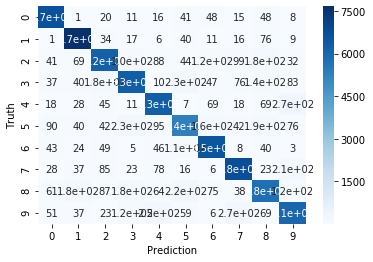

In [20]:
from sklearn.model_selection import StratifiedKFold

metrics, cm = cross_validate_pca(LogisticRegression, StratifiedKFold(3),
                                 pd.DataFrame(X), pd.Series(y),
                                 params={'solver': 'lbfgs'},
                                 n_components=0.95)
print_results(metrics, 'LR-PCA')
plot_cm(cm)

In [21]:
def plot_results(result_df, title, plot_type='bar'):
    ind = np.arange(len(result_df))
    fig, ax = plt.subplots(figsize=(20, 10))
    width = 1 / len(result_df.columns)
    if plot_type == 'bar':
        plot = lambda index, data, label: ax.bar(index, data, width=width, label=label)
    elif plot_type == 'plot':
        plot = lambda index, data, label: ax.plot(index, data, label=label)
    plot(ind, result_df['accuracy'], 'Accuracy')
    plot(ind+width, result_df['precision'], 'Precision')
    plot(ind+2*width, result_df['recall'], 'Recall')
    plot(ind+3*width, result_df['fscore'], 'fscore')
    
    ax.set_title(title)
    ax.set_ylabel('Scores')
    ax.set_xlabel(result_df.index.name)
    ax.set_xticks(ind + 3 * width / 2)
    ax.set_xticklabels(result_df.index)
    ax.autoscale()
    ax.legend()
    return ax

def test_pca(X, y, classifier, pca_values, classifier_const_params=None,
                kfold=None,
                normalizer=None):
    X = X.copy()
    if classifier_const_params is None:
        classifier_const_params = {}
    if kfold is None:
        kfold = StratifiedKFold(10)
    if normalizer is not None:
        normalizer.fit(X)
        X_preprocessed = normalizer.transform(X.values)
        X[:] = X_preprocessed
    param = 'n_components'
    data = {param: [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'fscore': [],
            'cm': []}
    for index, value in enumerate(pca_values):
        clf = classifier
        (accuracy,
         precision,
         recall,
         fscore,
         mislabeled,
         total), cm = cross_validate_pca(clf,
                                         kfold,
                                         X, y,
                                         params={**classifier_const_params},
                                         n_components=value)
        data[param].append(value)
        data['accuracy'].append(accuracy)
        data['precision'].append(precision)
        data['recall'].append(recall)
        data['fscore'].append(fscore)
        data['cm'].append(cm)
    
    df = pd.DataFrame(data).set_index(param)
    return plot_results(df, f'{clf.__class__.__name__} - {param}', plot_type='plot'), df

(<matplotlib.axes._subplots.AxesSubplot at 0x1a215496d8>,
               accuracy  precision    recall    fscore  \
 n_components                                            
 0.50          0.782300   0.776600  0.777341  0.774458   
 0.60          0.841257   0.837738  0.838253  0.837461   
 0.70          0.873557   0.870931  0.871229  0.870838   
 0.75          0.883914   0.881689  0.881805  0.881522   
 0.80          0.893300   0.891469  0.891471  0.891327   
 0.85          0.902000   0.900392  0.900326  0.900210   
 0.90          0.907257   0.905795  0.905713  0.905614   
 0.95          0.910271   0.908953  0.908847  0.908763   
 0.99          0.774671   0.782424  0.771683  0.770980   
 1.00          0.303343   0.180456  0.290132  0.210109   
 
                                                              cm  
 n_components                                                     
 0.50          [[6183, 0, 44, 163, 15, 227, 177, 56, 34, 4], ...  
 0.60          [[6514, 0, 40, 42, 38, 73, 9

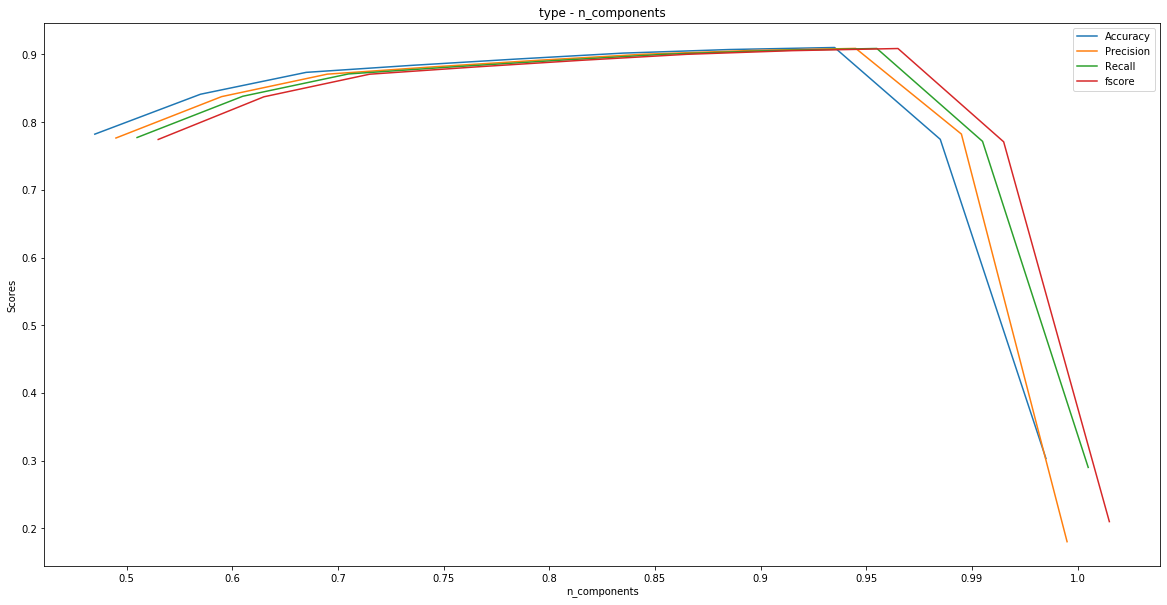

In [22]:
test_pca(pd.DataFrame(X), pd.Series(y), LogisticRegression, classifier_const_params={'solver': 'lbfgs'},
         kfold=StratifiedKFold(3), pca_values=[0.5, 0.6, 0.7, .75, .8, .85, .9, .95, .99, 1])